In [1]:
import sys
sys.path.insert(0,'dtaidistance-master')
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.interpolate
from pandas import DataFrame
from IPython.display import clear_output
from dtaidistance import dtw, dtw_visualisation as dtwvis, clustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.pyplot import *
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib.lines import Line2D
import seaborn as sns
from os import listdir

from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Иерархическая кластеризация
<!--- Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Hierarchical clustering groups together the data points with similar characteristics --->
Иерархическая кластеризация это тип обучения без учителя в котором алгоритм используется для кластперизации неразмеченных данных. Иерархическая кластеризация группирует данные в группы со схожими характеристиками

<!---## Steps to perform hierarchical clustering
Following are the steps involved in agglomerative clustering:
1. At the start, treat each data point as one cluster. Therefore, the number of clusters at the start will be `n`, while `n` is an integer representing the number of data points
2. Form a cluster by joining the two closest data points resulting in `n-1` clusters.
3. Form more clusters by joining the two closest clusters resulting in `n-2`f clusters.
4. Repeat the above three steps until one big cluster is formed.
5. Once single cluster is formed, dendrograms are used to divide into multiple clusters depending upon the problem--->
## Алгоритм иерархической кластеризации
1. В начале каждая точка воспринимается как кластер. Следовательно, в начале число кластепров будет `n`, где `n` число сэмплов в датасете
2. Создать кластер путем объединения двух самых похожил сэмплов `n-1` кластепров
3. Сформировать еще класте объединяя две ближайших фэмпла получая `n-2` кластеров
4. Повторять до тех пор пока не образуется 1 кластер
5. Когда сформирован 1 кластер дендрограмма может быть использована для визуализации кластеров

In [2]:
df = pd.DataFrame.from_dict({'x' : [0, 1, 3, 4, 3, 2.5, 1, 4],
                             'y' : [1, 3, 2, 1, 1, 0.5, 2, 0],
                             'phi' : [10, 11, 8, 7, 9, 7, 10, 9]
                             })
df

,x,y,phi
0,0.0,1.0,10
1,1.0,3.0,11
2,3.0,2.0,8
3,4.0,1.0,7
4,3.0,1.0,9
5,2.5,0.5,7
6,1.0,2.0,10
7,4.0,0.0,9


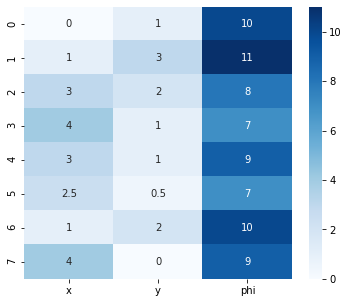

In [3]:
plt.figure(figsize=(6, 5))
sns.heatmap(df,
            annot=True,
            cmap='Blues',
            cbar=True);

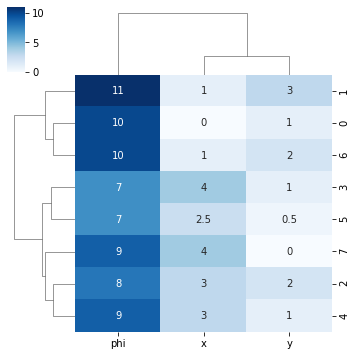

In [4]:
sns.clustermap(df, 
               figsize=(5, 5), 
               annot=True, 
               cmap='Blues');

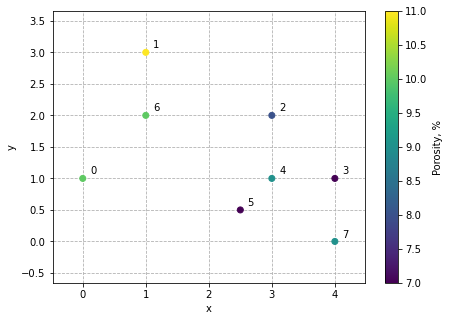

In [5]:
def plot_df(df):
    plt.figure(figsize=(7, 5))
    plt.scatter(df['x'], df['y'], c=df['phi'], zorder=2)
    
    
    colorbar = plt.colorbar()
    colorbar.set_label(label='Porosity, %', labelpad=5.5, y=0.5, rotation=90)

    COEF_LABEL = 0.05
    shift_x = df['x'].mean()*COEF_LABEL
    shift_y = df['y'].mean()*COEF_LABEL

    for i, label in enumerate(df.index):
        plt.text(np.array(df['x'])[i]+shift_x, np.array(df['y'])[i]+shift_y, label)
    
    plt.axis('equal')
    
    COEF_SHIFT = 10
    plt.xlim(df['x'].min()-shift_x*COEF_SHIFT, df['x'].max()+shift_x*COEF_SHIFT)
    plt.ylim(df['y'].min()-shift_y*COEF_SHIFT, df['y'].max()+shift_y*COEF_SHIFT)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls='--', zorder=1)
    
plot_df(df)

In [6]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,x,y,phi
0,0.000,0.333333,0.75
1,0.250,1.000000,1.00
2,0.750,0.666667,0.25
3,1.000,0.333333,0.00
4,0.750,0.333333,0.50
5,0.625,0.166667,0.00
6,0.250,0.666667,0.75
7,1.000,0.000000,0.50


<!--- There are different ways to find distance between the clusters. The distance itself can be Euclidean or Manhattan distance. --->
Существуют различные способы найти расстояние между сэмплами/кластеами. Метрики расстояния/похожести могут быть:
- `Euclidean distance`
    - $\sqrt{(\textrm{difference in sample #1})^2 + \textrm{...} + (\textrm{difference in sample #n})^2}$
    - Для #1 и #2 сэмплов $\sqrt{(0 - 0.25)^2 + (0.33 - 1)^2 +(0.75-1)^2}$

- `Manhattan distance`
    - $\mid{\textrm{difference in sample #1}} \mid + \textrm{...} + \mid{\textrm{difference in sample #n}} \mid$
- etc.

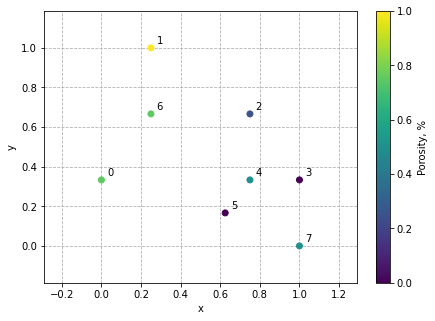

In [7]:
plot_df(df_scaled)

<!--- Following are some of the options to measure distance between two clusters:--->
Можно сравнивать каждый новый сэмпл используя:
- Среднее значение в кажом кластере<!---. Measure the distance between the centroids of two clusters---> (`centroid`)
- Ближайшую точку<!---. Measure the distance between the closest points of two clusters---> (`single`)
- Самую дальнюю точку<!---. Measure the distance between the farthest points of two clusters---> (`complete`)
- etc.

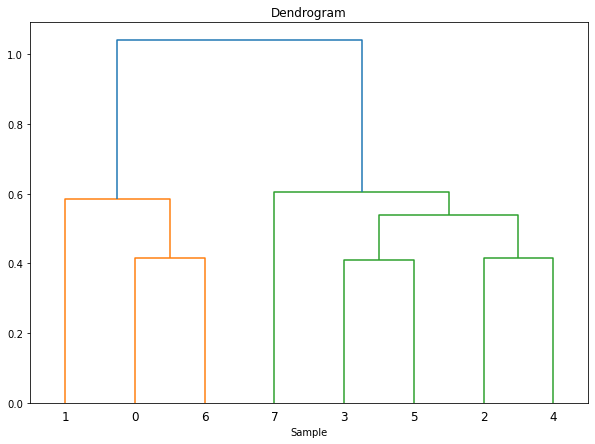

In [8]:
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram')  
links = shc.linkage(df_scaled, method='average', metric='euclidean')
dend = shc.dendrogram(links, orientation='top')
plt.xlabel('Sample')
plt.show()

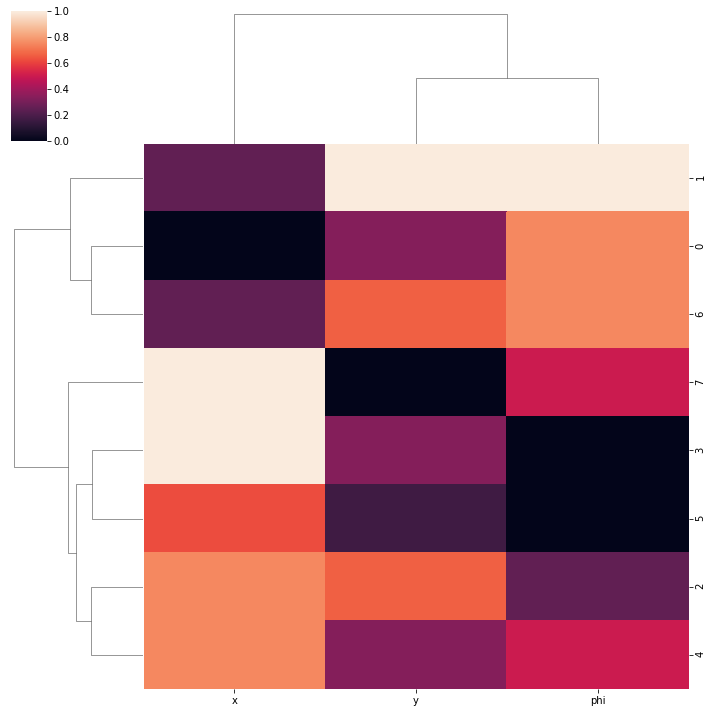

In [9]:
sns.clustermap(df_scaled, method='average', metric='euclidean');

# DTW
Алгоритм динамической трансформации временно́й шкалы (`DTW-алгоритм`, от англ. dynamic time warping) — алгоритм, позволяющий найти оптимальное соответствие между временными последовательностями. Впервые применен в распознавании речи, где использован для определения того, как два речевых сигнала представляют одну и ту же исходную произнесённую фразу. 

Временные ряды (time series) — широко распространенный тип данных, встречающийся, фактически, в любой научной области, и сравнение двух последовательностей является стандартной задачей. Для вычисления отклонения бывает достаточно простого измерения расстояния между компонентами двух последовательностей (Евклидово расстояние). Однако часто две последовательности имеют приблизительно одинаковые общие формы, но эти формы не выровнены по оси X. Чтобы определить подобие между такими последовательностями, мы должны «деформировать» ось времени одной (или обеих) последовательности, чтобы достигнуть лучшего выравнивания.

Измерение расстояния между двумя временными рядами нужно для того, чтобы определить их подобие и классификацию. Таким эффективным измерением является евклидова метрика. Для двух временных последовательностей это просто сумма квадратов расстояний от каждой n-ой точки одной последовательности до n-ой точки другой. Однако использование Евклидова расстояния имеет существенный недостаток: если два временных ряда одинаковы, но один из них незначительно смещен во времени (вдоль оси времени), то евклидова метрика может посчитать, что ряды отличаются друг от друга. `DTW-алгоритм` был введён для того, чтобы преодолеть этот недостаток и предоставить наглядное измерение расстояния между рядами, не обращая внимание как на глобальные, так и на локальные сдвиги на временной шкале.

Хотя алгоритм успешно используется во многих областях, он может выдавать неправильные результаты. Алгоритм может попытаться объяснить непостоянство оси y с помощью трансформации оси x. Это может привести к выравниванию, при котором одной точке первой последовательности ставится в соответствие большая подгруппа точек второй последовательности.

Другая проблема заключается в том, что алгоритм может не найти очевидное выравнивание двух рядов вследствие того, что особая точка (пик, впадина, плато, точка перегиба) одного ряда расположена немного выше или ниже соответствующей ей особой точки другого ряда.

<img src="figures/Euclidean-distance-vs-DTW-1280w.webp" alt="drawing" width="400"/>

Давайте визуализируем 2 кривые и применим к ним `DTW`, чтобы соединить их при этом минимизруя расстояние между двумя time series не обращая внимание на сдвиги по шкале x

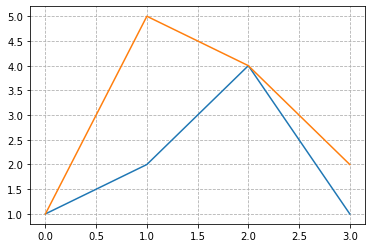

In [10]:
# Задание и визуализация двух кривых
s1 = np.array([1, 2, 4, 1])
s2 = np.array([1, 5, 4, 2])
plt.plot(s1)
plt.plot(s2)
plt.grid(ls = '--')

<img src="figures/Figure_1.png" alt="drawing" width="400"/>

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

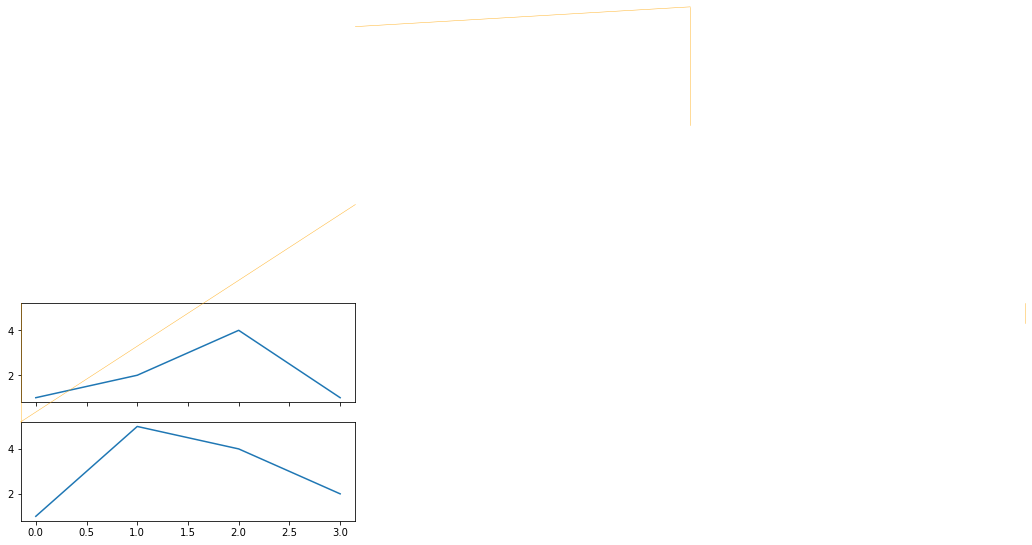

In [11]:
# Cоединение вершин кривых минимизуруя расстояние между двумя time series используя библиотеку dtaidistance
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)

Text(291.19642857142856, 0.5, 'y')

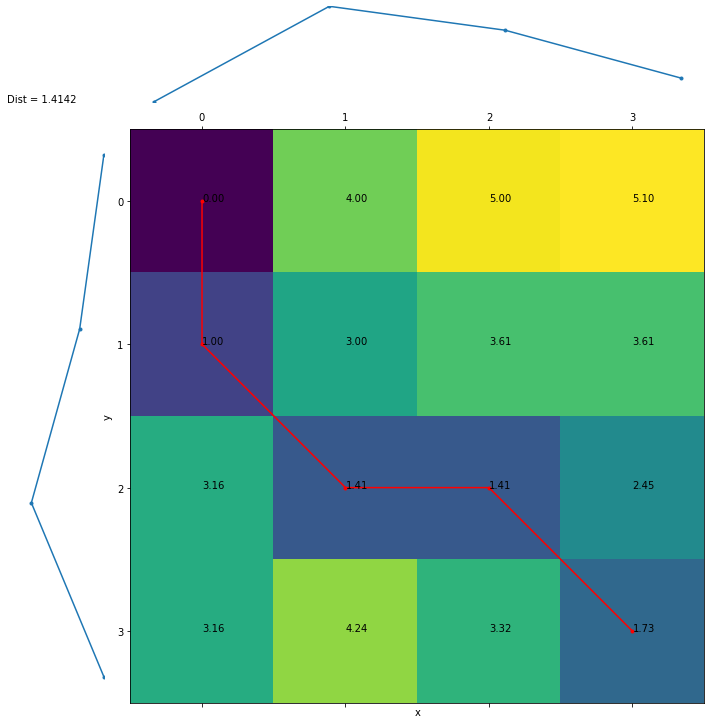

In [12]:
# визуализируем матрицу расстояний между точками
distance, paths = dtw.warping_paths(s1, s2)
path = dtw.warping_path(s1, s2)
dtwvis.plot_warpingpaths(s1, s2, path = path, paths = paths, shownumbers = True)
plt.xlabel('x')
plt.ylabel('y')
#plt.xticks([0, 1, 2, 3], s2)
#plt.yticks([0, 1, 2, 3], s1);

Общая формула для расчета кумулятивного расстояния между точакми:
<br>
<br>
$\sqrt{(x_i - y_j)^2 + (min(d[i-1, j-1], d[i-1, j], d[i, j-1]))^2} $, где
<br>
<br>
$min (a, b, c)$ означает выбор минимального значение из представленных внутри скобок,
<br>
<br>
$d[i-1, j]$ означает выбор элемента матрицы находящегося на 1 элемент левее по оси x и на том же месте по оси y по отношению к текущему элементу матрицы
<br>
<br>
Вспомним исходные кривые
<br>
`
s1 = np.array([1, 2, 4, 1])
s2 = np.array([1, 5, 4, 2])
`
<br>
и посчитаем несколько частных случаев помня что `s1` находится по оси **y**, а `s2` по **x**:
<br><br>
$\sqrt{(x_1 - y_0)^2 + (min(d[0, 0])^2} = \sqrt{(5 - 1)^2 + 0^2} = \sqrt{16 + 0} = 4 $
<br>
<br>
$\sqrt{(x_2 - y_0)^2 + (min(d[1, 0]))^2} = \sqrt{(4 - 1)^2 + 4^2} = \sqrt{9 + 16} = 5 $
<br>
<br>
$\sqrt{(x_3 - y_0)^2 + (min(d[2, 0]))^2} = \sqrt{(2 - 1)^2 + 5^2} = \sqrt{1 + 25} = 5.1 $
<br>
<br>
$\sqrt{(x_4 - y_3)^2 + (min(d[3, 3], d[4, 2], d[2, 2]))^2} = \sqrt{(2 - 4)^2 + min(1.41, 3.61, 3.61))^2} = \sqrt{4 + (1.41)^2} = 2.45 $
<br>
<br>
Помним, что счет начинается с нуля, а не с единицы [0, 1, 2, 3]. В папке есть файл "dtw.xlsx" в котором можно более детально изучить расчеты.
<br>
#### Итог:
Мы познакомились с тем как работает DTW алгоритм и готовы применять его на реальных данных.

# Кластеризация профилей добычи

In [30]:
# Загрузим датафрейм
path = 'HIST.txt'
df = pd.read_csv(path, delimiter = '\t')
# Визуализируем первые 5 строк датафрейма
df.head()

,DATE,WELL,QOIL,QWAT,QGAS,BHP
0,2011-02-01,WELL1,7946.073372,34.680479,NaN,2236.946357
1,2011-03-04,WELL1,8196.885023,34.680479,NaN,2236.946357
2,2011-04-04,WELL1,7888.974902,34.680479,NaN,2236.946357
3,2011-05-05,WELL1,8040.342778,29.393044,NaN,2236.946357
4,2011-06-05,WELL1,8206.164825,9.307177,NaN,2236.946357


# Watt

In [31]:
# посчитаем общее количество скважин в датафрейме
print(len(df['WELL'].unique()))
# выведем имена уникальных элементов датафтема в колонке 'WELL'
print(df['WELL'].unique())

16
['WELL1' 'WELL10' 'WELL1A' 'WELL1B' 'WELL2' 'WELL2A' 'WELL3' 'WELL3A'
 'WELL4' 'WELL4A' 'WELL5' 'WELL5A' 'WELL6' 'WELL7' 'WELL8' 'WELL9']


In [32]:
# подготовим данные для кластеризации
# создадим датафрейм temp_df который будет содержать значения из колонки указанной в 3 строке этой ячейки
column = 'QOIL' # 'BHP' , 'QWAT'
temp_df = pd.DataFrame()
for i in df['WELL'].unique():
    temp = df.loc[df['WELL'] == i][column]  
    temp = temp.dropna()
    temp = temp.reset_index(drop = True)
    temp_df[i[4:]] = temp
temp_df = temp_df.fillna(0)
temp_df.head()

,1,10,1A,1B,2,2A,3,3A,4,4A,5,5A,6,7,8,9
0,7946.073372,6921.820804,8128.736957,7751.562887,6669.878461,6665.432892,8350.878569,7724.354569,8280.550662,8131.830260,8224.807453,7957.185856,8076.498701,8364.201055,8218.091506,6187.073777
1,8196.885023,7031.786463,7977.844973,8113.299721,6449.788560,6818.169559,8353.436638,7743.198648,7829.818046,8230.251332,7990.240978,7917.508379,7603.097992,8383.573446,8206.944065,6584.080705
2,7888.974902,6855.742893,7951.103058,7889.247859,6806.718405,6372.740506,7920.510933,8164.639354,8223.475231,8283.064223,7903.585950,8033.886950,8249.135106,7772.335530,7656.178470,6567.626397
3,8040.342778,6951.324528,7773.603514,7939.935350,6430.111241,6717.549615,8244.556709,8377.398510,7920.414343,8391.883093,7946.280304,8036.307143,8361.097520,7811.777401,7639.372592,6735.781471
4,8206.164825,7008.018640,8367.572056,8102.220248,6223.935618,6194.999314,8236.895827,7608.495940,7983.917399,7788.655852,7821.520657,8073.360619,8361.199849,8033.520968,7974.052639,6520.983647


Визуализируем профили добычи

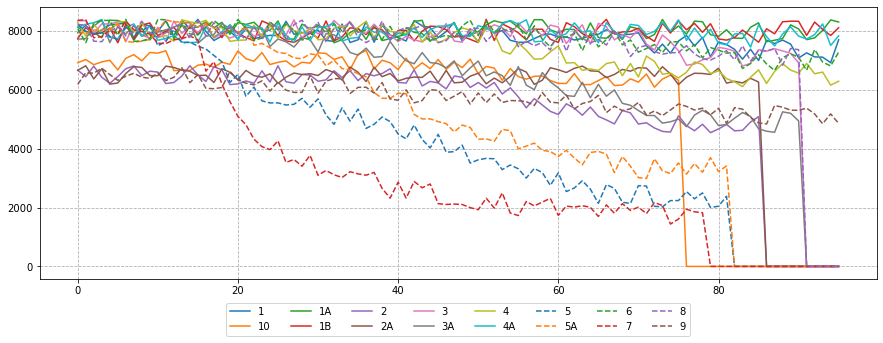

In [33]:
ls = ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 
      '--', '--', '--', '--', '--', '--', '--', '--', '--', ]
j = 0
plt.figure(figsize = (15, 5))
for i in temp_df.columns:
    plt.plot(temp_df.index, temp_df[i], label = i, ls = ls[j])
    j += 1
leg = plt.legend(loc = 'upper center', frameon = True, bbox_to_anchor = (0.5, -0.07),  ncol = 8)   
plt.grid(ls = '--')

- Можете ли мы выделить скважины которые по вашей "экспертной" оценке попадают в отдельные кластера?
- На какие свойства профилей вы опирались при определении кластеров?
<br>
<br>
Порстроение кластермапа

In [17]:
temp_df

,1,10,1A,1B,2,2A,3,3A,4,4A,5,5A,6,7,8,9
0,7946.073372,6921.820804,8128.736957,7751.562887,6669.878461,6665.432892,8350.878569,7724.354569,8280.550662,8131.830260,8224.807453,7957.185856,8076.498701,8364.201055,8218.091506,6187.073777
1,8196.885023,7031.786463,7977.844973,8113.299721,6449.788560,6818.169559,8353.436638,7743.198648,7829.818046,8230.251332,7990.240978,7917.508379,7603.097992,8383.573446,8206.944065,6584.080705
2,7888.974902,6855.742893,7951.103058,7889.247859,6806.718405,6372.740506,7920.510933,8164.639354,8223.475231,8283.064223,7903.585950,8033.886950,8249.135106,7772.335530,7656.178470,6567.626397
3,8040.342778,6951.324528,7773.603514,7939.935350,6430.111241,6717.549615,8244.556709,8377.398510,7920.414343,8391.883093,7946.280304,8036.307143,8361.097520,7811.777401,7639.372592,6735.781471
4,8206.164825,7008.018640,8367.572056,8102.220248,6223.935618,6194.999314,8236.895827,7608.495940,7983.917399,7788.655852,7821.520657,8073.360619,8361.199849,8033.520968,7974.052639,6520.983647
5,8239.809716,6677.723058,8357.933872,7602.946967,6449.883759,6235.754220,8318.776636,8156.163623,8301.178578,7742.580808,7705.480174,8225.995998,7853.698992,7906.379106,8149.088804,6324.276329
6,8265.861344,7072.492045,8252.441645,8226.150106,6719.654973,6555.466702,7638.276759,7898.062542,8320.739393,8113.152080,8129.270801,7639.771255,8395.372755,8343.330892,7838.660208,6465.959161
7,7774.503343,7198.841110,7687.904720,7713.476029,6813.891447,6791.912583,8212.046562,8184.908738,7964.061374,8243.824861,7910.281109,7621.709812,7649.230156,8042.440025,7996.954385,6563.473003
8,8247.305379,6986.581747,8094.097405,8204.035482,6484.440901,6762.556320,7861.906453,7823.900303,8280.429741,7821.339475,7997.708271,7653.924338,7665.137371,7983.012089,8336.071470,6431.883516
9,8164.315931,7271.581835,7698.085478,8274.009374,6635.575688,6486.964143,7760.229299,7944.769216,7863.161582,8173.175451,8199.135866,7715.417975,7746.367556,7901.824841,7940.560259,6391.901273


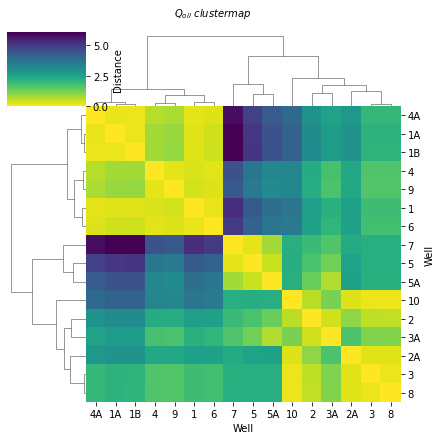

In [34]:
size = 10
series = temp_df.copy().T.to_numpy() #.as_matrix()
series /= np.atleast_2d(series.max(axis = 1)).T
#distances = pdist(series, dtw.distance_fast)
distances = pdist(series, dtw.distance)
a = pd.DataFrame(data = squareform(distances), index = temp_df.columns, columns = temp_df.columns)
cg = sns.clustermap(a, cmap = 'viridis_r', figsize = (6, 6))
cg.fig.suptitle(r'$Q_{oil}\ clustermap$', size = size)
plt.ylabel('Distance')
ax = cg.ax_heatmap
ax.set_xlabel('Well', size = size)
ax.set_ylabel('Well', size = size)
cg.fig.subplots_adjust(top = 0.92)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0);

Построение дендрограммы

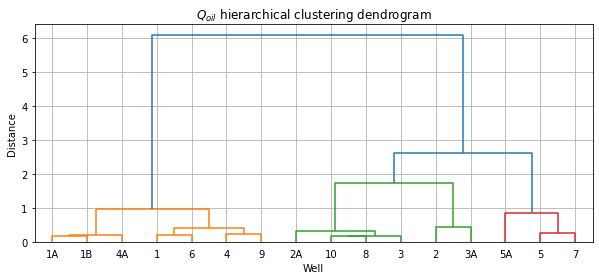

In [35]:
plt.figure(figsize = (10, 4))
links = linkage(distances, method='complete', metric='euclidean', optimal_ordering = True)
plt.title(r'$Q_{oil}$'+' hierarchical clustering dendrogram')
plt.xlabel('Well', fontsize = 10)
plt.ylabel('Distance')
dn = dendrogram(links, color_threshold = 2, leaf_font_size = 10, 
                labels = temp_df.columns, leaf_rotation = 0)
plt.grid()

- Совпадают ли ваши "экспертные" кластера с тем, что получилось путем кластеризации с помощью алгоритма DTW?
- Какие скважины не совпадают с вашей оценкой?
<br>
<br>
Создадим датафрейм с именем скажины и ее принадлежность к кластеру 

0
[0, 2, 3, 8, 9, 12, 15]
['1', '1A', '1B', '4', '4A', '6', '9']
---
1
[1, 4, 5, 6, 7, 14]
['10', '2', '2A', '3', '3A', '8']
---
2
[10, 11, 13]
['5', '5A', '7']
---


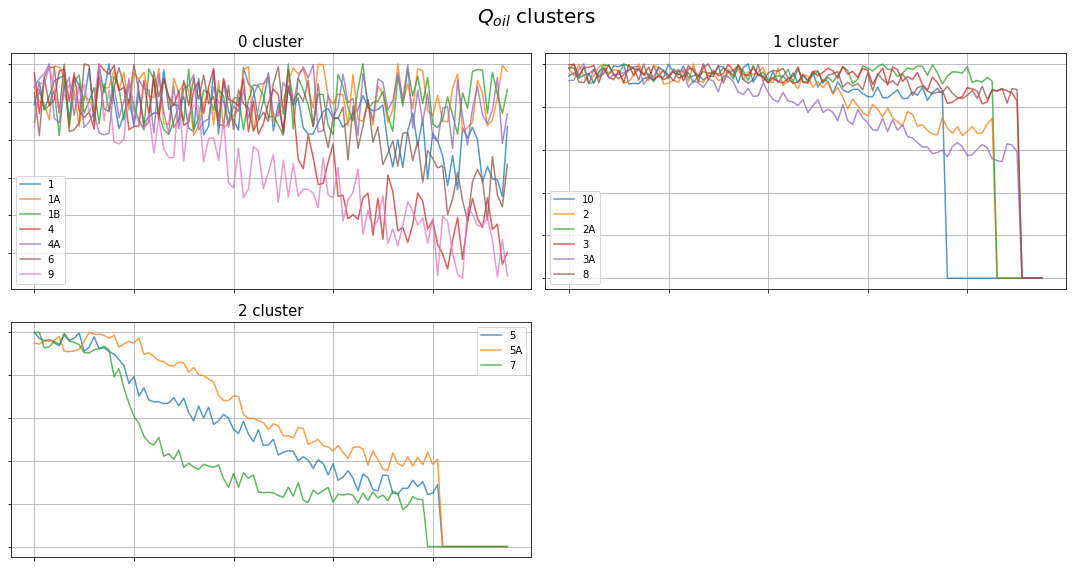

In [36]:
well_names_list = temp_df.columns
well_names_list = np.asarray(well_names_list)
final_well_list = []
final_cluster_list = []

def visualize_clusters(series, links, num_clusters, 
                       num_series_to_draw = 3,
                       make_gray = False):
    
    results = fcluster(links, num_clusters, criterion = 'maxclust')
    s = pd.Series(results)
    clusters = s.unique()
    ncols = 2
    nrows = np.ceil(len(clusters) / float(ncols)).astype(int)

        
    count = 0
    f, axs = subplots(ncols = ncols, nrows = nrows, figsize = (15, 4 * nrows))
    for row in range(nrows):
        for col in range(ncols):
            
            ax = axs[row, col] if nrows > 1 else axs[col]
            cluster_idx = row * ncols + col
            if cluster_idx >= len(clusters):
                ax.axis('off')
                break
            print(count)
            cluster_indices = s[s == cluster_idx + 1].index
            num_series_to_select = min(num_series_to_draw, len(cluster_indices))
            cluster_indices = np.random.choice(cluster_indices, num_series_to_select, replace = False)
            print(sorted(cluster_indices))
            #print(type(cluster_indices))
            well_list = []
            for i in well_names_list[sorted(cluster_indices)]:
                well_list.append(i)
            print(well_list)
            cluster_list = []
            for i in well_names_list[sorted(cluster_indices)]:
                cluster_list.append(count)
            print('---')
            series_to_plot = series[sorted(cluster_indices), :]
            plt.suptitle(r'$Q_{oil}$'+' clusters', fontsize = 20)
            q = 0
            for y in series_to_plot:
                if make_gray:
                    ax.plot(y, color = 'gray', alpha = 0.75)
                else:
                    ax.plot(y, alpha = 0.75, label = well_list[q])
                ax.set_title(str(count) + ' cluster', fontsize = 15)
                ax.get_xaxis().set_ticklabels([])
                ax.get_yaxis().set_ticklabels([])
                q += 1
            final_well_list.append(well_list)
            final_cluster_list.append(cluster_list)
            count += 1
            ax.grid(True)  
            ax.legend()
            
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
num_clusters = 3
num_series_to_draw = 100
make_gray = False
visualize_clusters(np.array(series), links, num_clusters, num_series_to_draw, make_gray)

Создадим xlsx-файл с именем скважины в колонце 'Well' и соответствующим ей кластером в колонке 'Cluster'

In [37]:
flattened_wells = [y for x in final_well_list for y in x]
flattened_clusters = [y for x in final_cluster_list for y in x]
wells_and_clusters = pd.DataFrame({'Well': flattened_wells, 'Cluster': flattened_clusters})
wells_and_clusters.to_excel('Clusters/Qoil.xlsx')
wells_and_clusters.head(20)

,Well,Cluster
0,1,0
1,1A,0
2,1B,0
3,4,0
4,4A,0
5,6,0
6,9,0
7,10,1
8,2,1
9,2A,1


Визуализуруем полученные профили добычи

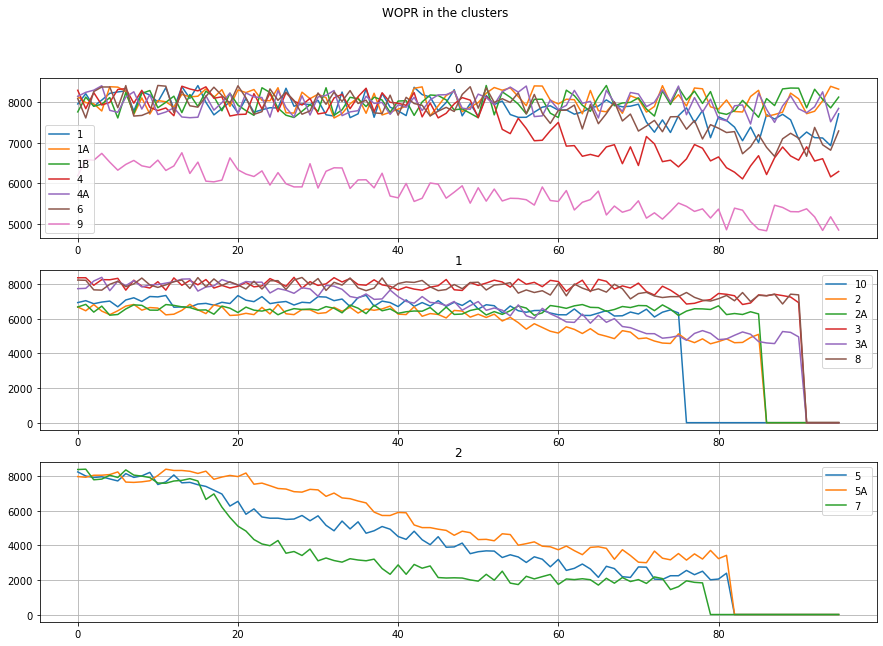

In [38]:
plt.figure(figsize = (15, 10))
plt.suptitle('WOPR in the clusters')
nrows = 3
ncols = 1
index = 1

for cluster in (wells_and_clusters['Cluster'].unique()):
    for well in (wells_and_clusters[wells_and_clusters['Cluster'] == cluster]['Well'].unique()):
        plt.subplot(nrows, ncols, index)
        plt.plot(temp_df[well], label = well)
    plt.title(cluster)
    plt.legend()
    plt.grid()
    index += 1

In [24]:
wells_and_clusters

,Well,Cluster
0,1,0
1,1A,0
2,1B,0
3,4,0
4,4A,0
5,6,0
6,9,0
7,10,1
8,2,1
9,2A,1


- Какие скважины выбиваются из общего паттерна кластера?
- Переместите эти скважны в правильные кластера

In [39]:
# Возможное решение
wells_and_clusters.iloc[6, 1] = 1 # 9
wells_and_clusters.iloc[12, 1] = 0 # 8
wells_and_clusters.iloc[11, 1] = 0 # 3A
wells_and_clusters.iloc[10, 1] = 0 # 3

wells_and_clusters

,Well,Cluster
0,1,0
1,1A,0
2,1B,0
3,4,0
4,4A,0
5,6,0
6,9,1
7,10,1
8,2,1
9,2A,1


Давайте визулизируем полученные кластера на карте

In [40]:
# Для этого сначала определем необходимые функции для отрисовки кластеров на карте используя ячейки Вороного

def discrete_cmap(N, base_cmap = None):
    #Create an N-bin discrete colormap from the specified input map
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def voronoi_finite_polygons_2d(vor, radius = None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

Загрузим датафрейм с ккординатами скважин

In [41]:
path = 'RAW DATA/Well Data_LAS/'
data = pd.read_excel(path + 'Coordinates_hist.xlsx')
data['Well'] = data['Well'].astype('str')
data

,X,Y,Well
0,1332664,283884,4A
1,1332664,283283,6
2,1315608,285360,8
3,1311508,280276,10
4,1333457,288754,9
5,1304242,283920,7
6,1309252,285269,5
7,1309235,284290,5A
8,1316093,282728,2
9,1316093,281726,2A


Объединим 2 датафрейма на колнку 'Well'

In [42]:
data = wells_and_clusters.merge(data, on = 'Well', how = 'left')
data

,Well,Cluster,X,Y
0,1,0,1322019,285971
1,1A,0,1322019,285314
2,1B,0,1322019,284657
3,4,0,1332664,285900
4,4A,0,1332664,283884
5,6,0,1332664,283283
6,9,1,1333457,288754
7,10,1,1311508,280276
8,2,1,1316093,282728
9,2A,1,1316093,281726


Визуализируем карту с полученными кластерами

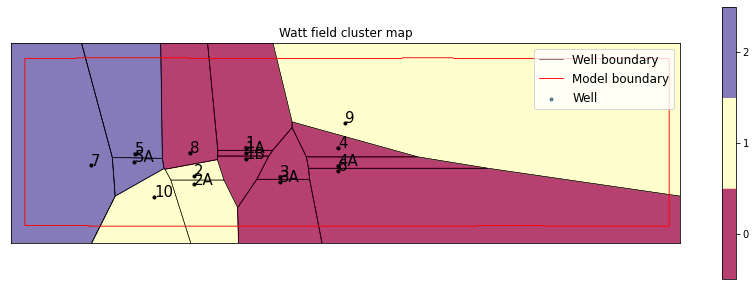

In [43]:
plt.figure(figsize = (15, 5))

number_of_clusters = len(data.Cluster.unique())

coordinates = np.array(data[['X', 'Y']])
points = coordinates
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

speed = np.array(data['Cluster'])
# find min/max values for normalization
minima = min(speed)
maxima = max(speed)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin = minima, vmax = maxima, clip=True)
mapper = cm.ScalarMappable(norm = norm, cmap = cm.Spectral)

# plot borders and fill of Voronoi cells
count = 0
for i in regions:
    points = vertices[i]
    x = points[:, 0]
    y = points[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    plt.plot(x, y, 'k', linewidth = .5)
    plt.fill(*zip(*points), alpha = .75, color = mapper.to_rgba(speed[count]))
    count +=1
plt.plot(x, y, 'k', linewidth = .5, label = 'Well boundary')

# plot well locations
coordinates = np.array(data[['X', 'Y']]) 
points = coordinates    
plt.plot(points[:,0], points[:,1], 'ko',  markersize = 3)

plt.xlim(1295000, 1372000) 
plt.ylim(275000, 298000)
plt.axes().set_aspect(1)

path = 'Polygons_Watt/Watt_model_boundary'
file = open(path, 'r')
x_polygon = []
y_polygon = []
for line in file:
    x_temp = float(line.split(' ', 1)[0])
    y_temp = float(line.split(' ', 1)[1].split(' ', 1)[0])
    x_polygon.append(x_temp)
    y_polygon.append(y_temp)
file.close()
x_polygon = x_polygon[:-1]
y_polygon = y_polygon[:-1]
polygon = np.column_stack((x_polygon, y_polygon))
plt.plot(x_polygon, y_polygon, 'red', linewidth = .9, label = 'Model boundary')

plt.scatter(data.X, data.Y, cmap = discrete_cmap(number_of_clusters, 'Spectral'), 
    c = data.Cluster, marker='o', lw = .5, edgecolors = 'black', s = 10, alpha = 0.75, label = 'Well')

for label, x, y in zip(data.Well, data.X, data.Y):
    plt.annotate(label, xy = (x, y), size = 15)


legend = plt.legend(loc = 'upper right', shadow = False, 
                    fontsize = 'large')
legend.get_frame()

plt.axes().set_aspect(1)
plt.yticks(np.arange(275000, 298000, 5000))
plt.xticks(np.arange(1295000, 1372000, 5000));
plt.colorbar(ticks = range(number_of_clusters))
plt.clim(-0.5, number_of_clusters - 0.5)
plt.title('Watt field cluster map')
plt.xticks([])
plt.yticks([])
plt.show()

Задание:
- Прокластеризуйте профили добычи воды и забойного давления
- Попробуйте найти оптимальное количество кластеров и соответвующие им скважины для всех трех time series ($Q_{oil}, Q_{water}, BHP$)
- Как пространственно меняются кластера по площяди месторождения?
- Как можно объяснить устойчивость принадлежности скважин к определенным кластерам при использовании данных различной природы для зонирования?